In [1]:
import numpy as np
import pylab as pl 
import json as json
import pandas as pd
import math

/home/mauro/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
config=json.loads(open('settings.json','r').read())

In [5]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

### read the logs from CSV ###

In [6]:
logs = pd.read_csv('log_sec.csv', index_col = False)
#logs.drop('timestamp', axis=1)
logs.drop('timestamp', axis=1)

,date,time,temperature,pressure,humidity,avg_pitch_,avg_roll,max_pitch,max_roll,wave height,wave period
0,2025-09-01,23:54:12,40.233,1016.896,66.766,1.4,1.1,0,0,0.0000,0.0000
1,2025-09-01,23:57:12,40.290,1016.835,67.005,1.2,1.7,0,0,0.1458,6.0000
2,2025-09-02,00:00:13,40.452,1016.806,66.432,1.0,1.0,0,0,0.1431,4.8649
3,2025-09-02,00:03:13,40.412,1016.776,66.043,0.7,1.5,0,0,0.2831,4.8649
4,2025-09-02,00:06:13,40.365,1016.752,65.915,0.6,1.4,0,0,0.3680,18.0000
5,2025-09-02,00:09:13,40.388,1016.712,65.850,0.7,0.9,0,0,0.1916,4.8649
6,2025-09-02,00:12:13,40.369,1016.700,65.813,0.6,0.7,0,0,0.2669,4.6154
7,2025-09-02,00:15:13,40.261,1016.699,64.012,0.7,1.0,0,0,0.2413,4.5000
8,2025-09-02,00:18:13,40.219,1016.695,65.047,0.8,3.1,0,0,0.2519,4.0909
9,2025-09-02,00:21:13,39.895,1016.697,64.658,0.8,5.5,0,0,0.1460,4.0909


#### reindex on datetime ####

In [7]:
logs["datetime"] = pd.to_datetime(logs["timestamp"], unit="s")
logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
logs['pressure'] = logs.pressure.astype(int)
logs.set_index('datetime', inplace=True)

### Plot ###

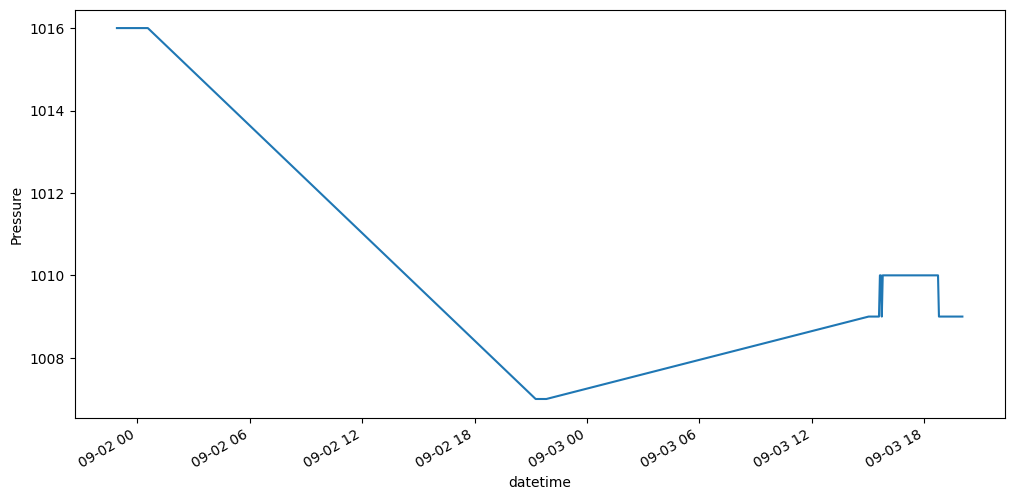

In [8]:
pl.ylabel('Pressure')
logs['pressure'].plot(figsize=[12,6])
pl.show()

#### Resample by hour ####

In [9]:
#hourly_logs = logs.resample('h').first()
hourly_logs = logs.resample('h').mean()

resample() fills in missing datapoints with NaN values, which cause gaps in the chart. We use dropna() to eliminate those.

<Axes: xlabel='datetime', ylabel='Humidity'>

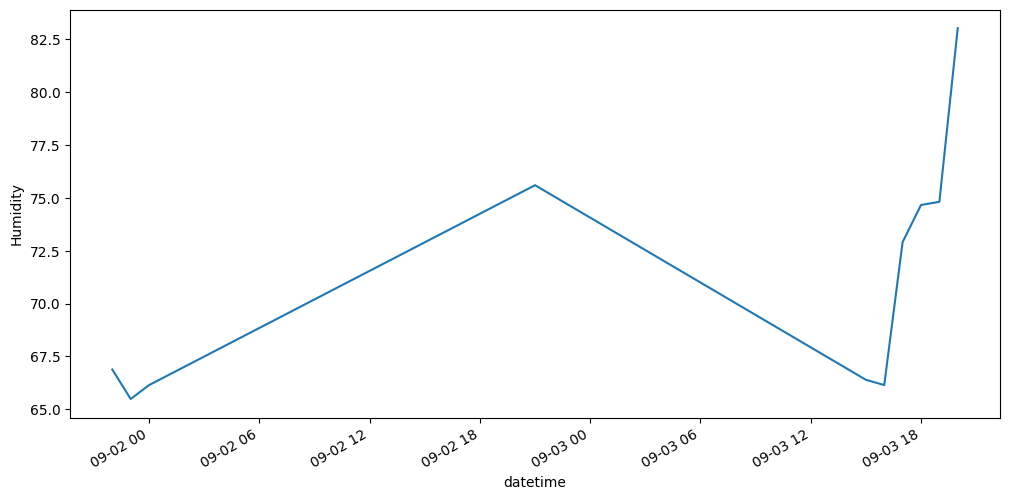

In [10]:
pl.ylabel('Humidity')
hourly_logs['humidity'].dropna().plot(figsize=[12,6])

<Axes: xlabel='datetime', ylabel='Pressure'>

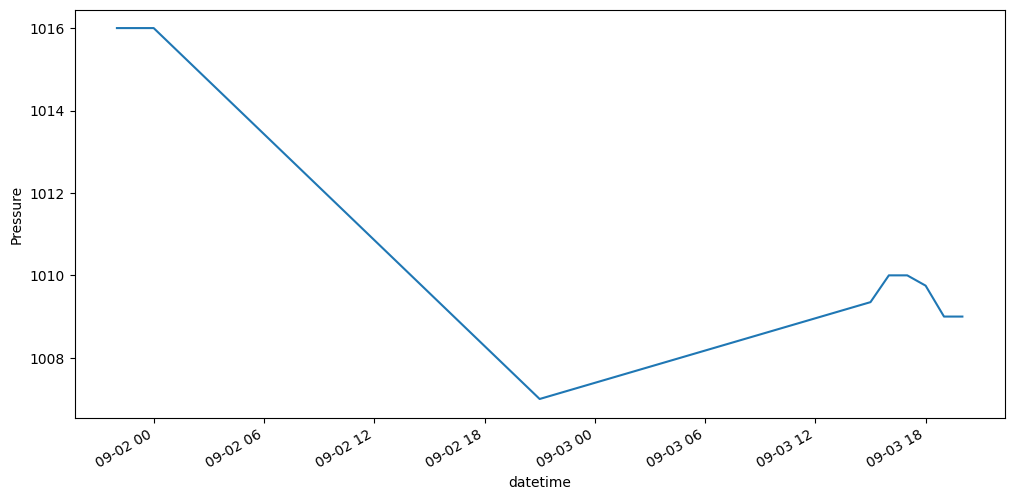

In [11]:
pl.ylabel('Pressure')
hourly_logs['pressure'].dropna().plot(figsize=[12,6])

### Debugging ###

In [12]:
npydir = 'npyfiles/'
run = '2025_09_02_00_24' # manual simulation of about 1 mt oscillations

In [13]:
freqs    = np.load(f'{npydir}freqs_{run}.npy')
signal   = np.load(f'{npydir}signal_{run}.npy')
amp_spec = np.load(f'{npydir}amp_spec_{run}.npy')
heights  = np.load(f'{npydir}heights_{run}.npy')
print('signal: ', len(signal), 'amp_spec: ', len(amp_spec))

signal:  720 amp_spec:  38


In [14]:
#signal = np.load(f'{npydir}signal_corr.npy')

In [15]:
w=40
mavg_signal = moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

720 681


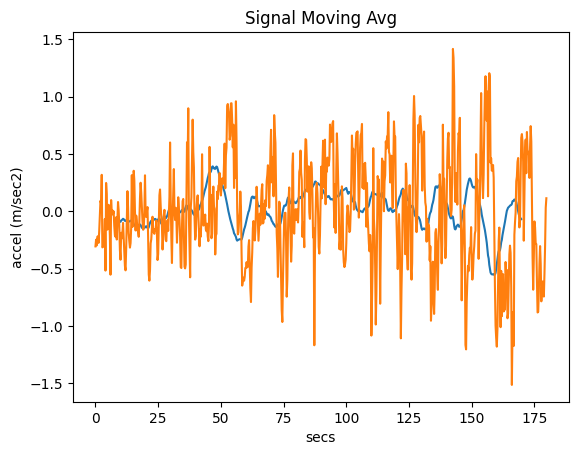

In [16]:
pl.title('Signal Moving Avg')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(w, ls-w )],mavg_signal[w:ls-w])
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal[0:ls])
pl.show()

subtract moving average from signal to clean low frequencies

In [17]:
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

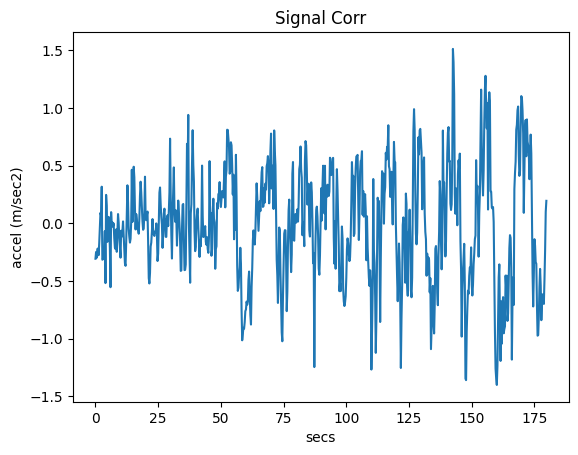

In [18]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [19]:
np.save(f'{npydir}signal_corr', signal_corr)

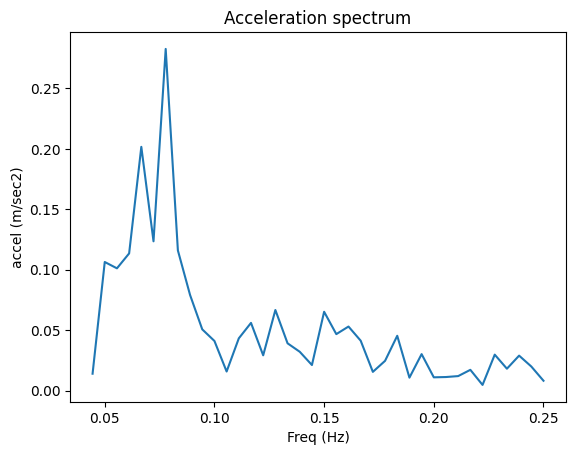

In [20]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.show()

In [21]:
w=4
mavg = moving_average(amp_spec, w)
max_index = np.argmax(mavg)+int(w/2)
dom_freq = freqs[max_index]
dom_per = 1/dom_freq
dom_per

12.857142857142858

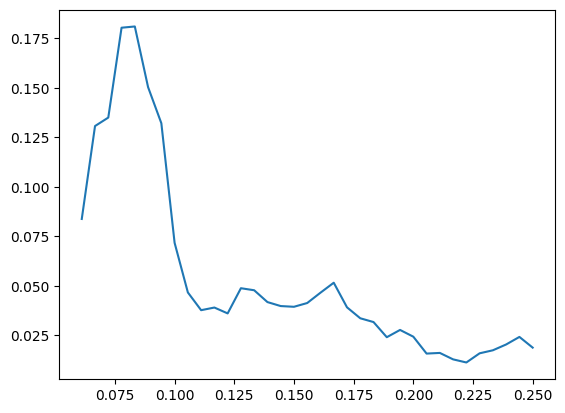

In [22]:
mavg = pl.plot(freqs[3:], mavg)

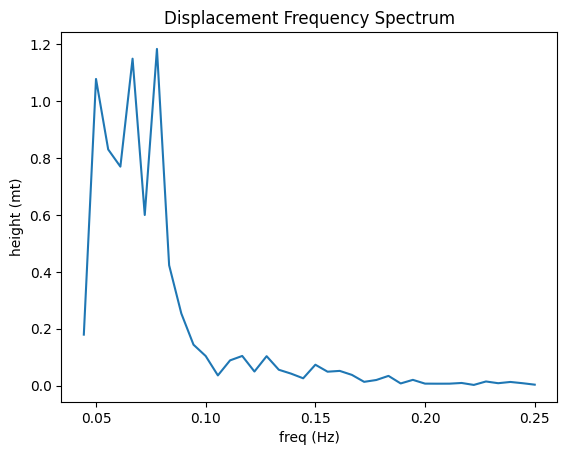

In [23]:
pl.title('Displacement Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.show()

In [24]:
avg_acc = sum(amp_spec)/(len(amp_spec))
avg_acc

0.0533289325536009

In [25]:
heights[2:]

array([0.83019134, 0.76979036, 1.14931179, 0.59977169, 1.18358522,
       0.42307715, 0.2535531 , 0.14386651, 0.10399047, 0.03589004,
       0.08871168, 0.10424736, 0.04949829, 0.10344042, 0.05574642,
       0.04217878, 0.02568094, 0.07342105, 0.0489098 , 0.05171105,
       0.03765248, 0.01323889, 0.01972568, 0.03417638, 0.00760108,
       0.02021969, 0.00695351, 0.00673114, 0.00682413, 0.00927069,
       0.00240979, 0.01452404, 0.00843058, 0.01284121, 0.00845331,
       0.00330294])

In [26]:
max_index = np.argmax(heights[2:])
max_index

4

Power spectral density

In [27]:
psd = (heights[2:]**2)/freqs[2:]
psd

array([1.24059180e+01, 9.69671779e+00, 1.98137637e+01, 4.98082262e+00,
       1.80112368e+01, 2.14793127e+00, 7.23253235e-01, 2.19150761e-01,
       1.08140168e-01, 1.22030030e-02, 7.08278658e-02, 9.31500972e-02,
       2.00461173e-02, 8.37385072e-02, 2.33074757e-02, 1.28091542e-02,
       4.56584194e-03, 3.59376727e-02, 1.53782234e-02, 1.65974462e-02,
       8.50625684e-03, 1.01768658e-03, 2.18870212e-03, 6.37104414e-03,
       3.05875136e-04, 2.10258359e-03, 2.41756838e-04, 2.20418733e-04,
       2.20588853e-04, 3.96672513e-04, 2.61319466e-05, 9.26112626e-04,
       3.04605456e-04, 6.90265263e-04, 2.92329746e-04, 4.36377660e-05])

In [28]:
m0  = sum(psd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

2.467915908976399

Amplitude Spectral Density

In [29]:
asd = np.sqrt(psd)

In [30]:
m0  = sum(asd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

1.431300326098888

#### calculate SWH from time series ####

this makes no sense as it is calculated on acceleration, not displacement

In [31]:
m0 = np.var(signal)

In [32]:
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

1.8022150338644123